In [1]:
import pandas as pd
import os
import glob
import ast
import zipfile
import matplotlib
from neo4j import GraphDatabase
import configparser
import textwrap
import math

# Data Preparation and Neo4j Ingest

In this notebook we format the 
[MIND-Large Dataset](https://msnews.github.io/#:~:text=Download-,The%20MIND%20dataset,-is%20free%20to)[[1]](#1)
training and validation sets and load them into a Neo4j graph. The work is divided into two primary sections in this notebook:

1. __[Prepare Data (Extract & Transform)](#prepare-data)__
2. __[Load Data Into Neo4j](#load-data)__

__To run this notebook please do the following:__
 - Download the training and validation sets from [MIND-Large Dataset](https://msnews.github.io) and place into the `SOURCE_DATA_PATH` set in the below [Setup Parameters](#set-up) section.

 - Ensure the `NEO4J_IMPORT_DIR`, `NEO4j_IMPORT_PATH`, and `NEO4J_PROPERTIES_FILE` are set correctly for your environemnt in the below [Setup Parameters](#set-up) section.

__Other Prerequisites:__
- Neo4j >= 4.3.x. This notebook was tested with [Neo4j Desktop](https://neo4j.com/download-center/#desktop) and should work for other on-prem installations.
- [APOC library](https://neo4j.com/labs/apoc/4.3/installation/).  This project was tested with APOC 4.3. 
- Notebook tested with Python=3.8

<a id="1">[1]</a>
Fangzhao Wu, Ying Qiao, Jiun-Hung Chen, Chuhan Wu, Tao Qi, Jianxun Lian, Danyang Liu, Xing Xie, Jianfeng Gao,
 Winnie Wu and Ming Zhou. MIND: A Large-scale Dataset for News Recommendation. ACL 2020.

## <a id="set-up">Setup Parameters</a>

#### Directory Settings

In [2]:
# The directory where MINDsmall_train.zip and MINDsmall_dev.zip exist
SOURCE_DATA_PATH = './data/'

`NEO4J_IMPORT_DIR` sets the the directory to put formatted csvs in for Neo4j load.
File locations for each OS are listed in the [Neo4j Operations Manual](https://neo4j.com/docs/operations-manual/current/configuration/file-locations). We recommend putting files in Neo4j’s `import` directory, as it keeps the environment secure. However, if you need to access files in other locations, you can find out which setting to alter in our [manual](https://neo4j.com/docs/cypher-manual/current/clauses/load-csv/#query-load-csv-introduction).

In [3]:
NEO4J_IMPORT_DIR = '/Users/zachblumenfeld/Library/Application Support/Neo4j Desktop/Application/relate-data/' + \
    'dbmss/dbms-fa90436a-1b9d-410d-a552-6191a6f481af/import'

`NEO4j_IMPORT_PATH` sets the path to use during CSV load. This will be 'file:///' by default and aligns with the local Neo4j `import` directory setup. 
See https://neo4j.com/developer/guide-import-csv/#_reading_csv_files for more details and customization

In [4]:
NEO4j_IMPORT_PATH = 'file:///'

#### Neo4j Settings
The `NEO4J_PROPERTIES_FILE` is an ini configuration file for Neo4j properties so this notebook can connect to
your Neo4j instance and load data. The ini file should be formatted as follows
```
[NEO4J]
PASSWORD=<password>
DATABASE=<database name, is 'neo4j' by default>
HOST=<host uri>

```

Set `NEO4J_PROPERTIES_FILE` to None or any non-existent location to use the below defaults
```
HOST = 'neo4j://localhost'
DATABASE = 'neo4j'
PASSWORD = 'password'
```

In [5]:
NEO4J_PROPERTIES_FILE = None # '/Users/zachblumenfeld/devtools/aura-news-demo.ini'

#### Impression Chunk Size
The number of rows to work with at once when reading from source behaviors/impressions files. recommend keeping
this below 100,000 - ish unless you know your machine can handle more rows efficiently.

In [6]:
IMPRESSION_CHUNK_SIZE = 100_000

## <a id="prepare-data">Prepare Data (Extract & Transform)</a>
In this section we extract and transform the source data into formatted csv files to prepare for [loading into Neo4j](#load-data).
We will create the following csv files.  There are quite a few, but generally I find it is easier for heterogeneous
graphs with many attributes to split up more files than try and merge into fewer.

__News related graph elements__
1. `news.csv`: Nodes representing news articles
2. `categories.csv`: Nodes representing news article categories
3. `sub-category-of-category.csv`: Relationships representing the subcategories underneath each category
4. `news-belongs-to-sub-category.csv`: Relationships representing each news belonging to a primary subcategory
5. `entities.csv`: Nodes representing WikiData entities extracted from the news articles by Microsoft
6. `entity-encoding.csv`: TransE embeddings/encodings calculated by microsoft to be merged with the entity nodes
7. `news-title-about.csv`: Relationship representing a news title referencing a wikiData entity
8. `news-abstract-about.csv`: Relationship representing a news abstract referencing a wikiData entity

__User and impression related graph elements__
1. `users.csv`: Nodes representing anonymized users
2. `clicks-[0-9]*.csv`: Relationships representing users clicking on a News article from an impression. We will write multiple files for these.
4. `historic-clicks-[0-9]*.csv`: Relationships representing users having historically clcked an article according to the impression record. We will write multiple files for these.
5. `news-approxTime.csv`: The minimum known impression time for news articles.  This will be merged with the News nodes.
Some news article, in fact the majority, are not included in any impression within our sample, they are only referenced
historically and thus this field will be null for them.

### Unzip Source data

In [7]:
# training set data
with zipfile.ZipFile( SOURCE_DATA_PATH + "MINDlarge_train.zip","r") as zip_ref:
    zip_ref.extractall(SOURCE_DATA_PATH + "train")

In [8]:
# validation set data
with zipfile.ZipFile( SOURCE_DATA_PATH + "MINDlarge_dev.zip","r") as zip_ref:
    zip_ref.extractall(SOURCE_DATA_PATH + "validate")

### News Related Graph Elements

In [9]:
col_names = ['newsId', 'category', 'subcategory', 'title', 'abstract', 'url', 'titleEntities','abstractEntities']
news_train_df = pd.read_csv('./data/train/news.tsv', sep = '\t', header = None, names = col_names)
news_validate_df = pd.read_csv('./data/validate/news.tsv', sep = '\t', header = None, names = col_names)

In [10]:
news_and_entities_df = pd.concat([news_train_df, news_validate_df],ignore_index=True).drop_duplicates()

#### News Nodes

In [11]:
news_df = news_and_entities_df.drop(columns = ['titleEntities', 'abstractEntities'])

In [12]:
# clean up quotes for easier csv formatting
news_df.abstract = news_df.abstract.str.replace('"', "'")
news_df.title = news_df.title.str.replace('"', "'")

In [13]:
news_df.to_csv(f'{NEO4J_IMPORT_DIR}/news.csv', index = False)
news_df

,newsId,category,subcategory,title,abstract,url
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,https://assets.msn.com/labs/mind/AABmf2I.html
2,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html
3,N86255,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html
4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html
...,...,...,...,...,...,...
172942,N17002,tv,tvnews,More millennials looking to slow aging process...,Who wouldn't love to turn back Father Time and...,https://assets.msn.com/labs/mind/BBWr3iL.html
172944,N91753,lifestyle,lifestylehoroscope,Which Zodiac Is The Nicest? Zodiac Ranking Fro...,Is your zodiac sign the nicest or the meanest?...,https://assets.msn.com/labs/mind/BBWIskd.html
173129,N1106,travel,internationaltravel,"Overindulge in Delicious Snacks, Meals, and Tr...",Your appetite's about to be on easy street.,https://assets.msn.com/labs/mind/BBWD0dt.html
173166,N37954,tv,tvnews,'The Walking Dead' star Josh McDermitt says Th...,"Josh McDermitt, who plays Eugene, tells Inside...",https://assets.msn.com/labs/mind/BBWyOPQ.html


#### Category/Subcategory Nodes and Relationships

In [14]:
sub_category_rel_df = news_df[['newsId','category', 'subcategory']]
sub_category_rel_df.to_csv(f'{NEO4J_IMPORT_DIR}/news-belongs-to-sub-category.csv', index = False)
sub_category_rel_df

,newsId,category,subcategory
0,N88753,lifestyle,lifestyleroyals
1,N45436,news,newsscienceandtechnology
2,N23144,health,weightloss
3,N86255,health,medical
4,N93187,news,newsworld
...,...,...,...
172942,N17002,tv,tvnews
172944,N91753,lifestyle,lifestylehoroscope
173129,N1106,travel,internationaltravel
173166,N37954,tv,tvnews


In [15]:
category_rel_df = news_df[['category','subcategory']].drop_duplicates()
category_rel_df.to_csv(f'{NEO4J_IMPORT_DIR}/sub-category-of-category.csv', index = False)
category_rel_df

,category,subcategory
0,lifestyle,lifestyleroyals
1,news,newsscienceandtechnology
2,health,weightloss
3,health,medical
4,news,newsworld
...,...,...
98382,autos,autosmidsize
98424,sports,soccer_fifa_wwc
99221,entertainment,entertainmenttv
100131,autos,autoslosangeles


In [16]:
category_df = category_rel_df[['category']].drop_duplicates()
category_df.to_csv(f'{NEO4J_IMPORT_DIR}/categories.csv', index = False)
category_df

,category
0,lifestyle
1,news
2,health
8,sports
10,weather
13,entertainment
14,foodanddrink
19,autos
27,travel
34,video


In [17]:
sub_category_df = category_rel_df[['subcategory']]
sub_category_df

,subcategory
0,lifestyleroyals
1,newsscienceandtechnology
2,weightloss
3,medical
4,newsworld
...,...
98382,autosmidsize
98424,soccer_fifa_wwc
99221,entertainmenttv
100131,autoslosangeles


In [18]:
#we have some subcategory duplicates
dup_sub_categories = sub_category_df.subcategory[sub_category_df.subcategory.duplicated()].tolist()
category_rel_df.loc[category_rel_df.subcategory.isin(dup_sub_categories)].sort_values('subcategory')

,category,subcategory
34,video,animals
1952,kids,animals
11085,travel,causes
8685,finance,causes
7284,news,causes
272,lifestyle,causes
606,health,causes
2485,lifestyle,holidays
29887,travel,holidays
59843,music,humor


Due to the above duplicates, let's define subcategories by complete hierarchy i.e. our
`subactegory-value = <category>-<subcategory>`. We can merge the string during the load process. This means that
`sub_category_rel_df` will serve as both the relationships and node source for sub category.

#### Prepare Title WikiData Entities

In [19]:
raw_title_entity_df = news_and_entities_df.drop(
    columns = ['category', 'subcategory', 'title', 'abstract', 'url', 'abstractEntities'])

In [20]:
def get_entities(entity_string):
    entity_list = []
    if not pd.isna(entity_string):
        entity_list = ast.literal_eval(entity_string)
    return entity_list

raw_title_entity_df['titleEntitiesFormatted'] = raw_title_entity_df.titleEntities.apply(get_entities)
raw_title_entity_df

,newsId,titleEntities,titleEntitiesFormatted
0,N88753,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...","[{'Label': 'Prince Philip, Duke of Edinburgh',..."
1,N45436,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...","[{'Label': 'IPad', 'Type': 'J', 'WikidataId': ..."
2,N23144,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{'Label': 'Adipose tissue', 'Type': 'C', 'Wik..."
3,N86255,"[{""Label"": ""Drug Enforcement Administration"", ...","[{'Label': 'Drug Enforcement Administration', ..."
4,N93187,[],[]
...,...,...,...
172942,N17002,[],[]
172944,N91753,[],[]
173129,N1106,"[{""Label"": ""World Pipe Band Championships"", ""T...","[{'Label': 'World Pipe Band Championships', 'T..."
173166,N37954,"[{""Label"": ""Negan"", ""Type"": ""R"", ""WikidataId"":...","[{'Label': 'Negan', 'Type': 'R', 'WikidataId':..."


In [21]:
raw_title_entity_df = raw_title_entity_df.explode('titleEntitiesFormatted', ignore_index=True)
raw_title_entity_df = raw_title_entity_df.drop(columns = ['titleEntities']).dropna().reset_index(drop=True)
raw_title_entity_df

,newsId,titleEntitiesFormatted
0,N88753,"{'Label': 'Prince Philip, Duke of Edinburgh', ..."
1,N88753,"{'Label': 'Charles, Prince of Wales', 'Type': ..."
2,N88753,"{'Label': 'Elizabeth II', 'Type': 'P', 'Wikida..."
3,N45436,"{'Label': 'IPad', 'Type': 'J', 'WikidataId': '..."
4,N45436,"{'Label': 'Walmart', 'Type': 'O', 'WikidataId'..."
...,...,...
124227,N1106,"{'Label': 'World Pipe Band Championships', 'Ty..."
124228,N37954,"{'Label': 'Negan', 'Type': 'R', 'WikidataId': ..."
124229,N37954,"{'Label': 'The Whisperers', 'Type': 'W', 'Wiki..."
124230,N37954,"{'Label': 'Josh McDermitt', 'Type': 'P', 'Wiki..."


In [22]:
title_ent_df = pd.json_normalize(raw_title_entity_df.titleEntitiesFormatted)
title_ent_df

,Label,Type,WikidataId,Confidence,OccurrenceOffsets,SurfaceForms
0,"Prince Philip, Duke of Edinburgh",P,Q80976,1.000,[48],[Prince Philip]
1,"Charles, Prince of Wales",P,Q43274,1.000,[28],[Prince Charles]
2,Elizabeth II,P,Q9682,0.970,[11],[Queen Elizabeth]
3,IPad,J,Q2796,0.999,[42],[iPads]
4,Walmart,O,Q483551,1.000,[0],[Walmart]
...,...,...,...,...,...,...
124227,World Pipe Band Championships,U,Q2954009,1.000,[58],[World]
124228,Negan,R,Q15378790,1.000,[83],[Negan]
124229,The Whisperers,W,Q1134147,1.000,[44],[The Whisperers]
124230,Josh McDermitt,P,Q6289166,1.000,[24],[Josh McDermitt]


In [23]:
title_entity_rel_df = pd.concat([title_ent_df, raw_title_entity_df[['newsId']]], axis=1)
title_entity_rel_df

,Label,Type,WikidataId,Confidence,OccurrenceOffsets,SurfaceForms,newsId
0,"Prince Philip, Duke of Edinburgh",P,Q80976,1.000,[48],[Prince Philip],N88753
1,"Charles, Prince of Wales",P,Q43274,1.000,[28],[Prince Charles],N88753
2,Elizabeth II,P,Q9682,0.970,[11],[Queen Elizabeth],N88753
3,IPad,J,Q2796,0.999,[42],[iPads],N45436
4,Walmart,O,Q483551,1.000,[0],[Walmart],N45436
...,...,...,...,...,...,...,...
124227,World Pipe Band Championships,U,Q2954009,1.000,[58],[World],N1106
124228,Negan,R,Q15378790,1.000,[83],[Negan],N37954
124229,The Whisperers,W,Q1134147,1.000,[44],[The Whisperers],N37954
124230,Josh McDermitt,P,Q6289166,1.000,[24],[Josh McDermitt],N37954


array([[<AxesSubplot:title={'center':'Confidence'}>]], dtype=object)

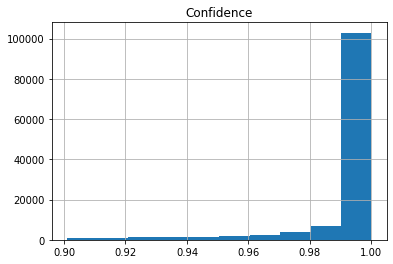

In [24]:
# Note that the Confidence scores seem to be skewed towards 1.0 with a cutoff at around 0.9...
# No low confidence included
title_entity_rel_df.hist('Confidence')

In [25]:
# we will extract the title entities and combine with the abstract ones below before writing
title_entity_df = title_entity_rel_df \
    .drop(columns = ['Confidence', 'OccurrenceOffsets', 'SurfaceForms', 'newsId']).drop_duplicates()
title_entity_df

,Label,Type,WikidataId
0,"Prince Philip, Duke of Edinburgh",P,Q80976
1,"Charles, Prince of Wales",P,Q43274
2,Elizabeth II,P,Q9682
3,IPad,J,Q2796
4,Walmart,O,Q483551
...,...,...,...
124210,You Know I Know (album),N,Q57754647
124218,Daniel Pineda (fighter),P,Q5218457
124228,Negan,R,Q15378790
124229,The Whisperers,W,Q1134147


#### Prepare Abstract WikiData Entities

In [26]:
raw_abstract_entity_df = news_and_entities_df.drop(
    columns = ['category', 'subcategory', 'title', 'abstract', 'url', 'titleEntities'])

In [27]:
def get_entities(entity_string):
    entity_list = []
    if not pd.isna(entity_string):
        entity_list = ast.literal_eval(entity_string)
    return entity_list

raw_abstract_entity_df['abstractEntitiesFormatted'] = raw_abstract_entity_df.abstractEntities.apply(get_entities)
raw_abstract_entity_df

,newsId,abstractEntities,abstractEntitiesFormatted
0,N88753,[],[]
1,N45436,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...","[{'Label': 'IPad', 'Type': 'J', 'WikidataId': ..."
2,N23144,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{'Label': 'Adipose tissue', 'Type': 'C', 'Wik..."
3,N86255,[],[]
4,N93187,"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...","[{'Label': 'Ukraine', 'Type': 'G', 'WikidataId..."
...,...,...,...
172942,N17002,"[{""Label"": ""Fountain of Youth"", ""Type"": ""U"", ""...","[{'Label': 'Fountain of Youth', 'Type': 'U', '..."
172944,N91753,[],[]
173129,N1106,[],[]
173166,N37954,"[{""Label"": ""Negan"", ""Type"": ""R"", ""WikidataId"":...","[{'Label': 'Negan', 'Type': 'R', 'WikidataId':..."


In [28]:
raw_abstract_entity_df = raw_abstract_entity_df.explode('abstractEntitiesFormatted', ignore_index=True)
raw_abstract_entity_df = raw_abstract_entity_df.drop(columns = ['abstractEntities']).dropna().reset_index(drop=True)
raw_abstract_entity_df

,newsId,abstractEntitiesFormatted
0,N45436,"{'Label': 'IPad', 'Type': 'J', 'WikidataId': '..."
1,N45436,"{'Label': 'Apple Inc.', 'Type': 'O', 'Wikidata..."
2,N23144,"{'Label': 'Adipose tissue', 'Type': 'C', 'Wiki..."
3,N93187,"{'Label': 'Ukraine', 'Type': 'G', 'WikidataId'..."
4,N75236,"{'Label': 'National Basketball Association', '..."
...,...,...
204882,N37954,"{'Label': 'Negan', 'Type': 'R', 'WikidataId': ..."
204883,N37954,"{'Label': 'The Whisperers', 'Type': 'W', 'Wiki..."
204884,N37954,"{'Label': 'Josh McDermitt', 'Type': 'P', 'Wiki..."
204885,N37954,"{'Label': 'Eugene Porter', 'Type': 'R', 'Wikid..."


In [29]:
abstract_ent_df = pd.json_normalize(raw_abstract_entity_df.abstractEntitiesFormatted)
abstract_ent_df

,Label,Type,WikidataId,Confidence,OccurrenceOffsets,SurfaceForms
0,IPad,J,Q2796,0.999,[12],[iPad]
1,Apple Inc.,O,Q312,0.999,[0],[Apple]
2,Adipose tissue,C,Q193583,1.000,[97],[belly fat]
3,Ukraine,G,Q212,0.946,[87],[Ukraine]
4,National Basketball Association,O,Q155223,1.000,[40],[NBA]
...,...,...,...,...,...,...
204882,Negan,R,Q15378790,1.000,[87],[Negan]
204883,The Whisperers,W,Q1134147,1.000,[52],[Whisperers]
204884,Josh McDermitt,P,Q6289166,1.000,[0],[Josh McDermitt]
204885,Eugene Porter,R,Q16211384,0.984,[26],[Eugene]


In [30]:
abstract_entity_rel_df = pd.concat([abstract_ent_df, raw_abstract_entity_df[['newsId']]], axis=1)
abstract_entity_rel_df

,Label,Type,WikidataId,Confidence,OccurrenceOffsets,SurfaceForms,newsId
0,IPad,J,Q2796,0.999,[12],[iPad],N45436
1,Apple Inc.,O,Q312,0.999,[0],[Apple],N45436
2,Adipose tissue,C,Q193583,1.000,[97],[belly fat],N23144
3,Ukraine,G,Q212,0.946,[87],[Ukraine],N93187
4,National Basketball Association,O,Q155223,1.000,[40],[NBA],N75236
...,...,...,...,...,...,...,...
204882,Negan,R,Q15378790,1.000,[87],[Negan],N37954
204883,The Whisperers,W,Q1134147,1.000,[52],[Whisperers],N37954
204884,Josh McDermitt,P,Q6289166,1.000,[0],[Josh McDermitt],N37954
204885,Eugene Porter,R,Q16211384,0.984,[26],[Eugene],N37954


array([[<AxesSubplot:title={'center':'Confidence'}>]], dtype=object)

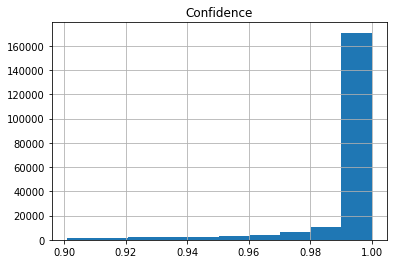

In [31]:
# Note that the Confidence scores seem to be skewed towards 1.0 with a cutoff at around 0.9...
# No low confidence included
abstract_entity_rel_df.hist('Confidence')

In [32]:
abstract_entity_df = abstract_entity_rel_df \
    .drop(columns = ['Confidence', 'OccurrenceOffsets', 'SurfaceForms', 'newsId']).drop_duplicates()
abstract_entity_df

,Label,Type,WikidataId
0,IPad,J,Q2796
1,Apple Inc.,O,Q312
2,Adipose tissue,C,Q193583
3,Ukraine,G,Q212
4,National Basketball Association,O,Q155223
...,...,...,...
204882,Negan,R,Q15378790
204883,The Whisperers,W,Q1134147
204884,Josh McDermitt,P,Q6289166
204885,Eugene Porter,R,Q16211384


#### Combine WikiData Entity Info and Write to CSV

In [33]:
entity_df = pd.concat([title_entity_df, abstract_entity_df], ignore_index=True).drop_duplicates()
entity_df

,Label,Type,WikidataId
0,"Prince Philip, Duke of Edinburgh",P,Q80976
1,"Charles, Prince of Wales",P,Q43274
2,Elizabeth II,P,Q9682
3,IPad,J,Q2796
4,Walmart,O,Q483551
...,...,...,...
62127,Paleolithic diet,U,Q533945
62128,Whole30,U,Q55423721
62130,Fountain of Youth,U,Q775332
62134,Eugene Porter,R,Q16211384


In [34]:
# we have some odd duplicates ids with different labels. Some make sense, others don't, lets just drop these for now
dup_wiki_ids = entity_df.WikidataId[entity_df.WikidataId.duplicated()].tolist()
entity_df.loc[entity_df.WikidataId.isin(dup_wiki_ids)].sort_values('WikidataId')

,Label,Type,WikidataId
5595,Major trauma,C,Q1064904
4550,Injury,C,Q1064904
2208,Roku,U,Q11399
1360,Rock music,B,Q11399
4690,Moon,L,Q1568
32079,Hindi,B,Q1568
4700,Vietnam,G,Q1741
15709,Vienna,G,Q1741
11390,Anguilla,G,Q25228
32214,Angola,G,Q25228


In [35]:
# drop odd duplicates and write
title_entity_rel_df = title_entity_rel_df[~title_entity_rel_df.WikidataId.isin(dup_wiki_ids)]
title_entity_rel_df.to_csv(f'{NEO4J_IMPORT_DIR}/news-title-about.csv', index = False)
title_entity_rel_df

,Label,Type,WikidataId,Confidence,OccurrenceOffsets,SurfaceForms,newsId
0,"Prince Philip, Duke of Edinburgh",P,Q80976,1.000,[48],[Prince Philip],N88753
1,"Charles, Prince of Wales",P,Q43274,1.000,[28],[Prince Charles],N88753
2,Elizabeth II,P,Q9682,0.970,[11],[Queen Elizabeth],N88753
3,IPad,J,Q2796,0.999,[42],[iPads],N45436
4,Walmart,O,Q483551,1.000,[0],[Walmart],N45436
...,...,...,...,...,...,...,...
124227,World Pipe Band Championships,U,Q2954009,1.000,[58],[World],N1106
124228,Negan,R,Q15378790,1.000,[83],[Negan],N37954
124229,The Whisperers,W,Q1134147,1.000,[44],[The Whisperers],N37954
124230,Josh McDermitt,P,Q6289166,1.000,[24],[Josh McDermitt],N37954


In [36]:
# drop odd duplicates and write
abstract_entity_rel_df = abstract_entity_rel_df[~abstract_entity_rel_df.WikidataId.isin(dup_wiki_ids)]
abstract_entity_rel_df.to_csv(f'{NEO4J_IMPORT_DIR}/news-abstract-about.csv', index = False)
abstract_entity_rel_df

,Label,Type,WikidataId,Confidence,OccurrenceOffsets,SurfaceForms,newsId
0,IPad,J,Q2796,0.999,[12],[iPad],N45436
1,Apple Inc.,O,Q312,0.999,[0],[Apple],N45436
2,Adipose tissue,C,Q193583,1.000,[97],[belly fat],N23144
3,Ukraine,G,Q212,0.946,[87],[Ukraine],N93187
4,National Basketball Association,O,Q155223,1.000,[40],[NBA],N75236
...,...,...,...,...,...,...,...
204882,Negan,R,Q15378790,1.000,[87],[Negan],N37954
204883,The Whisperers,W,Q1134147,1.000,[52],[Whisperers],N37954
204884,Josh McDermitt,P,Q6289166,1.000,[0],[Josh McDermitt],N37954
204885,Eugene Porter,R,Q16211384,0.984,[26],[Eugene],N37954


In [37]:
# drop odd duplicates and write
entity_df = entity_df[~entity_df.WikidataId.isin(dup_wiki_ids)]
entity_df.to_csv(f'{NEO4J_IMPORT_DIR}/entities.csv', index = False)
entity_df

,Label,Type,WikidataId
0,"Prince Philip, Duke of Edinburgh",P,Q80976
1,"Charles, Prince of Wales",P,Q43274
2,Elizabeth II,P,Q9682
3,IPad,J,Q2796
4,Walmart,O,Q483551
...,...,...,...
62127,Paleolithic diet,U,Q533945
62128,Whole30,U,Q55423721
62130,Fountain of Youth,U,Q775332
62134,Eugene Porter,R,Q16211384


#### WikiData Entity Embeddings

In [38]:
col_names = ['wikiEntityId'] + [f'x_{i}' for i in range(101)]
entity_emb_train_df = pd.read_csv('./data/train/entity_embedding.vec', sep = '\t', header = None, names = col_names)
entity_emb_validate_df = pd.read_csv('./data/validate/entity_embedding.vec', sep = '\t', header = None,
                                     names = col_names)
print(entity_emb_train_df.shape[0] + entity_emb_validate_df.shape[0])

75317


In [39]:
entity_emb_df = pd.concat([entity_emb_train_df, entity_emb_validate_df], ignore_index=True)

In [40]:
entity_emb_df.drop(inplace=True, columns=['x_100'])
entity_emb_df

,wikiEntityId,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_90,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99
0,Q34433,0.017808,-0.073256,0.102521,-0.059926,-0.060665,0.027027,-0.091728,-0.003057,-0.170798,...,-0.077962,0.013433,0.045894,-0.071253,0.086445,-0.120466,0.059235,-0.071865,0.058854,0.024765
1,Q41,-0.063388,-0.181451,0.057501,-0.091254,-0.076217,-0.052525,0.050500,-0.224871,-0.018145,...,-0.051949,0.001861,0.124535,-0.151043,-0.263698,-0.103607,0.020007,-0.101157,-0.091567,0.035234
2,Q56037,0.021550,-0.044888,-0.027872,-0.128843,0.066651,-0.072159,0.019879,-0.183956,0.080640,...,-0.077181,0.091477,0.091388,-0.027993,-0.112258,-0.231887,0.095612,-0.008997,-0.157394,0.088364
3,Q1860,0.060958,0.069934,0.015832,0.079471,-0.023362,-0.125007,-0.043618,0.134063,-0.121691,...,-0.070713,-0.014287,0.013578,0.099977,0.012199,-0.141138,0.056129,-0.133727,0.025795,0.051448
4,Q7737,-0.021237,0.176011,-0.078886,0.041470,0.136488,-0.063177,-0.013134,-0.048977,-0.072779,...,-0.136706,-0.162670,-0.101399,0.039757,0.123693,-0.129503,0.153088,-0.014275,-0.113625,-0.097839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75312,Q42225228,-0.051346,-0.028947,-0.075870,0.017512,-0.066910,-0.027968,0.020820,0.089614,-0.024825,...,0.038252,-0.024313,0.034771,0.044909,0.043314,-0.020466,-0.009811,0.028233,-0.015396,0.063876
75313,Q54860790,0.034682,-0.009413,-0.024317,0.073895,0.028052,0.028039,0.039260,0.017398,0.017743,...,-0.032887,0.034473,0.035736,0.008329,-0.049981,-0.025212,-0.018404,0.004110,0.013771,-0.008027
75314,Q54861457,-0.074425,-0.042263,-0.009502,0.033632,-0.092861,-0.067328,-0.009075,0.048518,-0.049856,...,0.016766,0.077567,0.055743,-0.035487,0.041439,-0.016274,0.031114,-0.001480,-0.057676,-0.018141
75315,Q54862508,-0.052323,-0.078029,-0.060925,-0.052536,0.006802,-0.070488,-0.081736,0.026385,-0.037127,...,-0.056357,0.045298,0.009842,-0.019821,-0.033952,-0.047436,0.062752,0.043236,0.032251,-0.001261


In [41]:
# concatenate embeddings into single array field with a ';' delimiter. 
# This format is especially conducive to the Neo4j load process
entity_emb_df['entityEmbedding'] = entity_emb_df.apply(lambda row:";".join(['%0.7f' % i for i in row.iloc[1:]]),
                                                       axis=1)
entity_emb_df = entity_emb_df.drop(columns = [f'x_{i}' for i in range(100)]).drop_duplicates()
entity_emb_df

,wikiEntityId,entityEmbedding
0,Q34433,0.0178080;-0.0732560;0.1025210;-0.0599260;-0.0...
1,Q41,-0.0633880;-0.1814510;0.0575010;-0.0912540;-0....
2,Q56037,0.0215500;-0.0448880;-0.0278720;-0.1288430;0.0...
3,Q1860,0.0609580;0.0699340;0.0158320;0.0794710;-0.023...
4,Q7737,-0.0212370;0.1760110;-0.0788860;0.0414700;0.13...
...,...,...
75061,Q5178745,-0.0117120;0.0026640;0.0100950;0.0092700;-0.00...
75077,Q5229702,-0.0138630;0.0029340;0.0232410;0.0146720;-0.06...
75147,Q5570391,-0.0117440;-0.0204840;-0.0028200;0.0209490;-0....
75154,Q61983615,0.0038860;-0.0204640;-0.0060140;0.0181820;-0.0...


In [42]:
# double check that we do not have duplicate embeddings like we did with the WikiDataLabels. 
# It looks like we have zero.
entity_emb_df.wikiEntityId.duplicated().sum()

0

In [43]:
entity_emb_df.to_csv(f'{NEO4J_IMPORT_DIR}/entity-embedding.csv', index = False)

### User and Impression Related Graph Elements

#### Write click events and aggregate other data from impressions

Due to the number of impressions (millions), I am using a chunking strategy to avoid out of memory errors, especialy as each impression needs to be expanded to extract the click events.  This should hopefully allow you to run this notebook locally on a standard desktop.

In [44]:
def listify(x):
    res = None
    if not pd.isna(x):
        res = x.split(' ')
    return res

class ImpressionError(Exception):
    def __init__(self, message):
        self.message = message

In [45]:
col_names = ['impressionId', 'userId', 'timeString', 'history', 'impressions']

user_dfs = []
historic_dfs = []
news_approx_time_dfs = []
click_iters = 0

previous_click_files =  glob.glob(f'{NEO4J_IMPORT_DIR}/clicks-[0-9]*.csv')
if len(previous_click_files) > 0:
    print(f'Removing previous file(s) for click events: {NEO4J_IMPORT_DIR}/clicks-[0-9]*.csv')
    for previous_click_file in previous_click_files:
        os.remove(previous_click_file)

for dataset in ['train', 'validate']:
    total_read = 0
    print(f'Beginning read of {dataset} set behaviors/impression...')
    print('================================')
    for chunk_df in pd.read_csv(f'./data/{dataset}/behaviors.tsv', sep = '\t', header = None, names = col_names,
                             chunksize = IMPRESSION_CHUNK_SIZE):

        print(f'\treading impressions {total_read}:{total_read + IMPRESSION_CHUNK_SIZE - 1} of {dataset} set')
        print('\t------------------------------')

        #define split set
        chunk_df['splitSet'] = dataset.upper()

        #set time variable
        chunk_df['time'] = pd.to_datetime(chunk_df.timeString, infer_datetime_format=True)

        #get the users
        print('\t\taggregating users...')
        user_dfs.append(chunk_df[['userId']].drop_duplicates())

        #aggregate historic clicks
        print('\t\taggregating historic clicks...')
        historic_df = chunk_df.groupby('userId').agg({'splitSet':'min', 'history': lambda x: set(list(x))})\
            .reset_index()

        # make sure the history vector isn't different for users across impressions.
        # if it is our analysis becomes more complex. We will do this once more on all historic_dfs post aggregation
        historic_df['numUniqueHistories'] = historic_df.history.apply(len)
        if historic_df[historic_df.numUniqueHistories > 1].shape[0] > 0:
             raise ImpressionError('Some users have discrepancies in click history across different impressions.')

        historic_df['historicClicks'] =  historic_df.history.apply(lambda x: next(iter(x)))
        historic_dfs.append(historic_df[['userId', 'historicClicks', 'splitSet']])

        # expand clicks
        print('\t\texpanding clicks...')
        chunk_df['impressionList'] = chunk_df.impressions.apply(listify)
        impression_click_df = chunk_df.loc[~chunk_df.impressionList.isnull(),
            ['impressionId', 'userId', 'time', 'impressionList', 'splitSet']].explode('impressionList')
        impression_click_df.rename(columns = {'impressionList':'newsIdHit'}, inplace=True)
        impression_click_df[["newsId", "userClickedCode"]] = impression_click_df.newsIdHit.str.split('-', expand=True)
        impression_click_df.drop(columns = ['newsIdHit'], inplace=True)

        # write click events
        print('\t\twriting clicks...')
        impression_click_df[impression_click_df.userClickedCode == '1'].drop(columns = ['userClickedCode']) \
            .to_csv(f'{NEO4J_IMPORT_DIR}/clicks-{click_iters}.csv', index = False)

        '''
        While I encourage you to explore, this demo will not utilize DID_NOT_CLICK events for sake of simplicity.
        In this context, DID_NOT_CLICKS are not the user necessarily disliking content which is evident by the fact 
        that users will often click and not click on the same news in different impressions.
        For this iteration of the demo will we focus mainly on maximizing clicks, not minimizing non-clicks.

        Also, keep in mind this is a very large number of relationships
        '''
        '''
        impression_click_df[impression_click_df.userClickedCode == '0'].drop(columns = ['userClickedCode']) \
            .to_csv(f'{NEO4J_IMPORT_DIR}/did-not-clicks.csv', index = False)
        '''

        # get approximate times for news
        print('\t\taggregating approx times for news...')
        news_approx_time_dfs.append(impression_click_df.groupby('newsId').agg({'time':'min'}).reset_index()
                .rename(columns={'time':'approxTime'}))

        total_read = total_read + IMPRESSION_CHUNK_SIZE
        click_iters += 1
        print('\t------------------------------')
    print(f'Completed {dataset} set.')
    print('================================')

Removing previous file(s) for click events: /Users/zachblumenfeld/Library/Application Support/Neo4j Desktop/Application/relate-data/dbmss/dbms-fa90436a-1b9d-410d-a552-6191a6f481af/import/clicks-[0-9]*.csv
Beginning read of train set behaviors/impression...
	reading impressions 0:99999 of train set
	------------------------------
		aggregating users...
		aggregating historic clicks...
		expanding clicks...
		writing clicks...
		aggregating approx times for news...
	------------------------------
	reading impressions 100000:199999 of train set
	------------------------------
		aggregating users...
		aggregating historic clicks...
		expanding clicks...
		writing clicks...
		aggregating approx times for news...
	------------------------------
	reading impressions 200000:299999 of train set
	------------------------------
		aggregating users...
		aggregating historic clicks...
		expanding clicks...
		writing clicks...
		aggregating approx times for news...
	------------------------------
	r

#### Historic clicks

In [46]:
historic_impression_df = pd.concat(historic_dfs, ignore_index=True)
historic_impression_df

,userId,historicClicks,splitSet
0,U1,N14639 N27258 N63237 N112729 N42180 N109816 N7...,TRAIN
1,U100004,N9375 N84273 N96000,TRAIN
2,U100006,N4796 N88769 N57930,TRAIN
3,U100010,N31043 N49079 N127287 N30299 N21475 N115743 N2...,TRAIN
4,U100015,N129420 N85056 N18399 N54978 N44826,TRAIN
...,...,...,...
2350407,U99982,N119785 N64765 N64496 N53360 N117682 N9375 N55...,VALIDATE
2350408,U99984,N121592 N127001,VALIDATE
2350409,U99989,N91 N108143 N26493 N15986 N82348 N71068 N23264...,VALIDATE
2350410,U99993,N67397 N67770 N41129 N128503 N51724 N72187 N91...,VALIDATE


In [47]:
historic_df = historic_impression_df.groupby('userId')\
    .agg({'splitSet':'min', 'historicClicks': lambda x: set(list(x))}).reset_index()

# make sure the history vector isn't different for users across all impressions
# if it is our analysis becomes more complex.
historic_df['numUniqueHistories'] = historic_df.historicClicks.apply(len)
if historic_df[historic_df.numUniqueHistories > 1].shape[0] > 0:
     raise ImpressionError('Some users have discrepancies in their click history across different impressions.')

In [48]:
historic_df['history'] =  historic_df.historicClicks.apply(lambda x: next(iter(x)))
historic_df.drop(columns =['historicClicks', 'numUniqueHistories'], inplace=True)
historic_df

,userId,splitSet,history
0,U0,TRAIN,N39011 N112324 N78884 N111503 N63941 N68426 N1...
1,U1,TRAIN,N14639 N27258 N63237 N112729 N42180 N109816 N7...
2,U10,TRAIN,N85722 N111503 N104737
3,U100,TRAIN,N99587 N61339 N129790 N12721 N100405 N103530 N...
4,U1000,TRAIN,N33446 N20131 N65823 N65823 N111503 N3992 N104...
...,...,...,...
750429,U99995,TRAIN,N71340 N85428 N112324 N72044 N9690 N79909 N232...
750430,U99996,TRAIN,N113476 N54005 N129955 N14121 N73408 N127336 N...
750431,U99997,TRAIN,N108284 N117102 N57945 N24344 N16097 N54360
750432,U99998,TRAIN,N11631 N56746 N91597 N99305 N2099 N42718 N8002...


In [69]:
previous_historic_click_files =  glob.glob(f'{NEO4J_IMPORT_DIR}/historic-clicks-[0-9]*.csv')
if len(previous_historic_click_files) > 0:
    print(f'Removing previous file(s) for historic click events: {NEO4J_IMPORT_DIR}/historic-clicks-[0-9]*.csv')
    for previous_historic_click_file in previous_historic_click_files:
        os.remove(previous_historic_click_file)

historic_click_iters = 0
historic_chunk_size = math.ceil(IMPRESSION_CHUNK_SIZE/5)
print(f'Beginning write of historic clicks...')
print('================================')
for i in range(0, historic_df.shape[0], historic_chunk_size):
    
    print(f'\twriting historic clicks {i}:{i + historic_chunk_size}')
    print('\t------------------------------')

    # subset dataframe
    print(f'\t\tsub-setting...')
    historic_chunk_df = historic_df.iloc[i:(i + historic_chunk_size)].copy()

    # expand on historic clicks
    print(f'\t\texpanding...')
    historic_chunk_df['historyList'] = historic_chunk_df.history.apply(listify)
    historic_chunk_df = historic_chunk_df.explode('historyList').rename(columns = {'historyList':'newsId'})

    # write historic clicks
    print(f'\t\twritting...')
    historic_chunk_df.to_csv(f'{NEO4J_IMPORT_DIR}/historic-clicks-{historic_click_iters}.csv', index = False)
    historic_click_iters += 1
    print('\t------------------------------')
print('Completed.')
print('================================')

Removing previous file(s) for historic click events: /Users/zachblumenfeld/Library/Application Support/Neo4j Desktop/Application/relate-data/dbmss/dbms-fa90436a-1b9d-410d-a552-6191a6f481af/import/historic-clicks-[0-9]*.csv
Beginning write of historic clicks...
	writing historic clicks 0:20000
	------------------------------
		sub-setting...
		expanding...
		writting...
	------------------------------
	writing historic clicks 20000:40000
	------------------------------
		sub-setting...
		expanding...
		writting...
	------------------------------
	writing historic clicks 40000:60000
	------------------------------
		sub-setting...
		expanding...
		writting...
	------------------------------
	writing historic clicks 60000:80000
	------------------------------
		sub-setting...
		expanding...
		writting...
	------------------------------
	writing historic clicks 80000:100000
	------------------------------
		sub-setting...
		expanding...
		writting...
	------------------------------
	writin

#### Users

In [50]:
user_df = pd.concat(user_dfs, ignore_index=True).drop_duplicates()
user_df.to_csv(f'{NEO4J_IMPORT_DIR}/users.csv', index=False)
user_df

,userId
0,U87243
1,U598644
2,U532401
3,U593596
4,U239687
...,...
2350346,U732274
2350354,U738824
2350370,U733415
2350371,U736502


#### Approximate News Times

News tends to be most relevant when it is recent and can lose relevance quickly with the passing of time.
As such, the date the news is published is important to consider for recommendation. Unfortunately in this case, we do
not have exact publish dates. To approximate we will use the minimum impression date.
This will get merged to all news nodes during ingest (some news are just historic and thus have no approximate times)

In [51]:
news_approx_time_df = pd.concat(news_approx_time_dfs, ignore_index=True)\
    .groupby('newsId').agg({'approxTime':'min'}).reset_index()
news_approx_time_df.to_csv(f'{NEO4J_IMPORT_DIR}/news-approx-time.csv', index=False)
news_approx_time_df

,newsId,approxTime
0,N10000,2019-11-09 08:25:03
1,N100003,2019-11-12 12:47:27
2,N100006,2019-11-10 19:02:42
3,N100007,2019-11-12 10:04:49
4,N100008,2019-11-10 16:30:59
...,...,...
29304,N99985,2019-11-13 19:59:29
29305,N99989,2019-11-11 18:26:03
29306,N99990,2019-11-12 16:01:05
29307,N99992,2019-11-12 16:16:03


## <a id="load-data">Load Data Into Neo4j</a>

In this section we will load the above transformed data into Neo4j. As a good rule of practice for Neo4j bulk loading,
I have found it ideal if you can follow the below pattern. Note that for this to work, each node should have some sort
of external unique id, or you must otherwise create one at ingest time.

1. __Set a uniqueness constraint__ on a property for each node label
2. __Load nodes__ using `MERGE` which is similar to an upsert pattern on the above uniqueness constraint
and is very well optimized in Neo4j
3. __Load relationships__ using `MATCH` and `MERGE` to find adjacent nodes on uniqueness constraint and upsert respectively

In [52]:
## Using an ini file for credentials, otherwise providing defaults
HOST = 'neo4j://localhost'
DATABASE = 'neo4j'
PASSWORD = 'password'

if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_PROPERTIES_FILE)
    HOST = config['NEO4J']['HOST']
    DATABASE = config['NEO4J']['DATABASE']
    PASSWORD = config['NEO4J']['PASSWORD']
    print('Using custom database properties')
else:
    print('Could not find database properties file, using defaults')

Could not find database properties file, using defaults


In [53]:
# helper function
def run(driver, query, params=None):
    with driver.session() as session:
        if params is not None:
            return [r for r in session.run(query, params)]
        else:
            return [r for r in session.run(query)]

In [70]:
driver = GraphDatabase.driver(HOST, auth=(DATABASE, PASSWORD))

### Set Uniqueness Constraints
This step is critical for performant loading with merge patterns

In [55]:
run(driver,'CREATE CONSTRAINT userId_unique IF NOT EXISTS ON (user:User) ASSERT user.userId  IS UNIQUE')

run(driver,'CREATE CONSTRAINT news_id_unique IF NOT EXISTS ON (news:News) ASSERT news.newsId IS UNIQUE')

run(driver,'CREATE CONSTRAINT wiki_id_unique IF NOT EXISTS ON (entity:WikiEntity) ASSERT entity.wikidataId IS UNIQUE')

run(driver,'CREATE CONSTRAINT category_subject_unique IF NOT EXISTS ON (category:Category) ASSERT category.subject IS UNIQUE')

run(driver,'CREATE CONSTRAINT sub_category_subject_unique IF NOT EXISTS ON (subcategory:Subcategory) ASSERT subcategory.subject IS UNIQUE')


[]

### Load Nodes

In [56]:
# user nodes
run(driver, textwrap.dedent("""\
    USING PERIODIC COMMIT 10000
    LOAD CSV WITH HEADERS FROM $file AS row
    MERGE(user:User {userId:row.userId})
    RETURN count(user)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'users.csv'}
)

[<Record count(user)=750434>]

In [57]:
# news nodes
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MERGE(news:News {
      newsId: row.newsId,
      category: row.category,
      subcategory: row.subcategory,
      title: row.title,
      url: row.url})
    WITH row, news
    WHERE row.abstract IS NOT null
    SET news.abstract = row.abstract
    RETURN count(news)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'news.csv'}
)

[<Record count(news)=98575>]

In [58]:
# set news approximate times
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MATCH(news:News {newsId: row.newsId})
    SET news.approxTime = datetime({ epochSeconds:apoc.date.parse(row.approxTime, 's', 'yyyy-MM-dd HH:mm:ss')})
    RETURN count(news)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'news-approx-time.csv'}
)

[<Record count(news)=29309>]

In [59]:
# load category nodes
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MERGE(category:Category {subject: row.category})
    RETURN count(category)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'categories.csv'}
)

[<Record count(category)=18>]

In [60]:
# load wikidata entity nodes
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MERGE(entity:WikiEntity {
        wikidataId: row.WikidataId,
        wikiLabel: row.Label,
        wikiType: row.Type,
        url: 'https://www.wikidata.org/wiki/' + row.WikidataId
      })
    RETURN count(entity)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'entities.csv'}
)

[<Record count(entity)=44065>]

In [61]:
# set wikidata entity encodings
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MATCH(entity:WikiEntity {wikidataId: row.wikiEntityId})
    SET entity.wikiEncoding = toFloatList(split(row.entityEmbedding, ';'))
    RETURN count(entity)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'entity-embedding.csv'}
)


[<Record count(entity)=42616>]

### Load Relationships

In [62]:
# load sub categories and hierarchy relationships
# Note: the below pattern (mixing node and relationship merges) has performance drawbacks with larger files
# We get away with it here because the total number of subcategories is very small (291)
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MERGE(subcategory:Subcategory {subject: row.category + '-' + row.subcategory})
    WITH subcategory, row
    MATCH(category:Category {subject: row.category})
    MERGE(subcategory)-[r:SUBCATEGORY_OF]->(category)
    RETURN count(r)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'sub-category-of-category.csv'}
)

[<Record count(r)=308>]

In [63]:
# load news-subcategory relationships
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MATCH(subcategory:Subcategory {subject: row.category + '-' + row.subcategory})
    MATCH(news:News {newsId: row.newsId})
    MERGE(news)-[r:BELONGS_TO_SUBCATEGORY]->(subcategory)
    RETURN count(r)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'news-belongs-to-sub-category.csv'}
)

[<Record count(r)=104151>]

In [64]:
# load news-title-about-wikiData-entity relationships
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MATCH(news:News {newsId: row.newsId})
    MATCH(entity:WikiEntity {wikidataId: row.WikidataId})
    MERGE(news)-[r:TITLE_ABOUT{ confidence: toFloat(row.Confidence)}]->(entity)
    RETURN count(r)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'news-title-about.csv'}
)

[<Record count(r)=124034>]

In [65]:
# load news-abstract-about-wikiData-entity relationships
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MATCH(news:News {newsId: row.newsId})
    MATCH(entity:WikiEntity {wikidataId: row.WikidataId})
    MERGE(news)-[r:ABSTRACT_ABOUT{ confidence: toFloat(row.Confidence)}]->(entity)
    RETURN count(r)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'news-abstract-about.csv'}
)

[<Record count(r)=204627>]

In [66]:
# load user click relationships
for i in range(click_iters):
    print(f'Loading clicks {i + 1} of {click_iters}')
    run(driver, textwrap.dedent("""\
        LOAD CSV WITH HEADERS FROM $file AS row
        MATCH(user:User {userId: row.userId})
        MATCH(news:News {newsId: row.newsId})
        MERGE(user)-[r:CLICKED {
          splitSet: row.splitSet,
          impressionId: row.impressionId,
          impressionTime: datetime({ epochSeconds:apoc.date.parse(row.time, 's', 'yyyy-MM-dd HH:mm:ss')})
        }]->(news)
        RETURN count(r)
        """),
        params = {'file': f'{NEO4j_IMPORT_PATH}clicks-{i}.csv'}
    )

Loading clicks 1 of 27
Loading clicks 2 of 27
Loading clicks 3 of 27
Loading clicks 4 of 27
Loading clicks 5 of 27
Loading clicks 6 of 27
Loading clicks 7 of 27
Loading clicks 8 of 27
Loading clicks 9 of 27
Loading clicks 10 of 27
Loading clicks 11 of 27
Loading clicks 12 of 27
Loading clicks 13 of 27
Loading clicks 14 of 27
Loading clicks 15 of 27
Loading clicks 16 of 27
Loading clicks 17 of 27
Loading clicks 18 of 27
Loading clicks 19 of 27
Loading clicks 20 of 27
Loading clicks 21 of 27
Loading clicks 22 of 27
Loading clicks 23 of 27
Loading clicks 24 of 27
Loading clicks 25 of 27
Loading clicks 26 of 27
Loading clicks 27 of 27


In [71]:
# load user historic click relationships
for i in range(historic_click_iters):
    print(f'Loading historic clicks {i + 1} of {historic_click_iters}')
    run(driver, textwrap.dedent("""\
        LOAD CSV WITH HEADERS FROM $file AS row
        MATCH(user:User {userId: row.userId})
        MATCH(news:News {newsId: row.newsId})
        MERGE(user)-[r:HISTORICALLY_CLICKED {splitSet: row.splitSet}]->(news)
        RETURN count(r)
        """),
        params = {'file': f'{NEO4j_IMPORT_PATH}historic-clicks-{i}.csv'}
    )

Loading historic clicks 1 of 38
Loading historic clicks 2 of 38
Loading historic clicks 3 of 38
Loading historic clicks 4 of 38
Loading historic clicks 5 of 38
Loading historic clicks 6 of 38
Loading historic clicks 7 of 38
Loading historic clicks 8 of 38
Loading historic clicks 9 of 38
Loading historic clicks 10 of 38
Loading historic clicks 11 of 38
Loading historic clicks 12 of 38
Loading historic clicks 13 of 38
Loading historic clicks 14 of 38
Loading historic clicks 15 of 38
Loading historic clicks 16 of 38
Loading historic clicks 17 of 38
Loading historic clicks 18 of 38
Loading historic clicks 19 of 38
Loading historic clicks 20 of 38
Loading historic clicks 21 of 38
Loading historic clicks 22 of 38
Loading historic clicks 23 of 38
Loading historic clicks 24 of 38
Loading historic clicks 25 of 38
Loading historic clicks 26 of 38
Loading historic clicks 27 of 38
Loading historic clicks 28 of 38
Loading historic clicks 29 of 38
Loading historic clicks 30 of 38
Loading historic cl

In [68]:
driver.close()